In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
from matplotlib.dates import DateFormatter

sys.path.append("../functions/")
from plot_style import plot_style
colors = plot_style("../functions/fonts/")
from import_functions import *

# first and last Monday
start_date, end_date  = datetime(2020, 3, 2), datetime(2020, 12, 21)
window = timedelta(days=7)
dates = pd.to_datetime(np.arange(start_date, end_date + window, window))

../functions/plot_style.py:21: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [2]:
def import_coeffs(country, ycol):
    with open("./output-time/" + country + "_" + ycol + "_time.pkl", "rb") as file:
        coeffs = pkl.load(file)
    return coeffs

def get_stats_OLS(coeffs, c, week, complete=False):
    if complete:
        k = "complete"
    else:
        k = c
    med = coeffs[k][week]['OLS']['params'][c]
    ci = coeffs[k][week]['OLS']['CI']
    q1, q2 = ci.loc[ci.index == c][0].values[0], ci.loc[ci.index == c][1].values[0]
    return med, q1, q2

In [3]:
def plot_policy(ax_str, country, color, label_xcoord=1.11, label=False):

    """
    This function plot the stringency index
    :param ax_str: axis
    :param country: name of the country
    :param color: color to use
    :param label_xcoord: x coordinate of the y label
    """
    # import data
    policy = import_policy(country, path_to_data="../../data/")
    # plot stringency index
    ax_str.plot(policy["StringencyIndex"], color=color, linestyle='--')
    # format dates
    ax_str.xaxis.set_major_formatter(DateFormatter("%b, %y"))
    # labels and title
    ax_str.tick_params(axis="x", rotation=30)
    if label:
        ax_str.set_ylabel("Stringency Index", fontsize=9, rotation=270, color=color)
    ax_str.yaxis.set_label_coords(x=label_xcoord, y=0.5)
    ax_str.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax_str.tick_params(axis="y", color=color, labelcolor=color, labelsize=8)
    # spines
    ax_str.spines["top"].set_visible(False)
    ax_str.spines['right'].set_edgecolor(color)
    # ax lim 
    ax_str.set_ylim(0, 105)
    ax_str.set_xlim(datetime(2020, 3, 2), datetime(2020, 12, 21))

def plot_country(country, ycol, ax1, ax2, ax3, title, label=False):
    
    # import data
    coeffs = import_coeffs(country, ycol)
    
    # get data
    r2s, delta_r2s, delta_aics = [], [], []
    med_mbps, q1_mbps, q2_mbps = [], [], []
    for i in range(len(dates)):
        r2s.append(coeffs['complete'][i]['OLS']['r2'])
        delta_r2s.append(coeffs['complete'][i]['OLS']['r2'] - coeffs['complete_nombps'][i]['OLS']['r2'])
        delta_aics.append(coeffs['complete'][i]['OLS']['aic'] - coeffs['complete_nombps'][i]['OLS']['aic'])
        med, q1, q2 = get_stats_OLS(coeffs, "download_mbps_fixed", i, complete=True)
        med_mbps.append(med)
        q1_mbps.append(q1)
        q2_mbps.append(q2)
        
    df = pd.DataFrame(data={"r2s": r2s, "delta_r2s": delta_r2s, "delta_aics": delta_aics,
                        "med_mbps": med_mbps, "q1_mbps": q1_mbps, "q2_mbps": q2_mbps}, index=dates)

    df = df.resample("W").mean()
    #.mean().resample("D").mean()
    #df = df.fillna(method='ffill')

    
    ax1.plot(df.index, df.med_mbps, color=colors[0])
    ax1.fill_between(df.index, df.q1_mbps, df.q2_mbps, alpha=0.3, linewidth=0, color=colors[0])
    ax2.plot(df.index, df.r2s, color=colors[1])
    ax3.plot(df.index, df.delta_aics, color=colors[3])
    
    ax1.set_title(title, weight='bold')
    if label:
        ax1.set_ylabel("$\\beta^{Mbps}$")
        ax2.set_ylabel("$R^2$")
        ax3.set_ylabel("$\\Delta_{AIC}$")
    
    for ax in [ax1, ax2, ax3]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis='y', labelsize=8)
        
    ax1.set_ylim(-0.1, 0.2)
    ax2.set_ylim(0.0, 0.7)
    ax3.yaxis.set_major_locator(plt.MaxNLocator(3))
    
    ax1.hlines(0, df.index[0], df.index[-1], linestyle="--", color='grey', linewidth=1)
    ax3.hlines(-2, df.index[0], df.index[-1], linestyle="--", color='grey', linewidth=1)
    
    ax1.set_yticks([0.0, 0.1, 0.2])
    ax2.set_yticks([0.25, 0.5, 0.75])
    
    if country == "el-salvador":
        label = True
    else:
        label = False
    plot_policy(ax1.twinx(), country, colors[4], label_xcoord=1.3, label=label)
    plot_policy(ax2.twinx(), country, colors[4], label_xcoord=1.3, label=label)
    
    ax1.grid(axis="y", linewidth=0.3)
    ax2.grid(axis="y", linewidth=0.3)
    ax3.grid(axis="y", linewidth=0.3)

    ax3.set_xticks([df.index[i] for i in np.arange(0, len(df.index), 5)])
    ax3.set_xticklabels([df.index[i].strftime("%b, %y") for i in np.arange(0, len(df.index), 5)])
    ax3.tick_params(axis='x', rotation=30, labelsize=6)

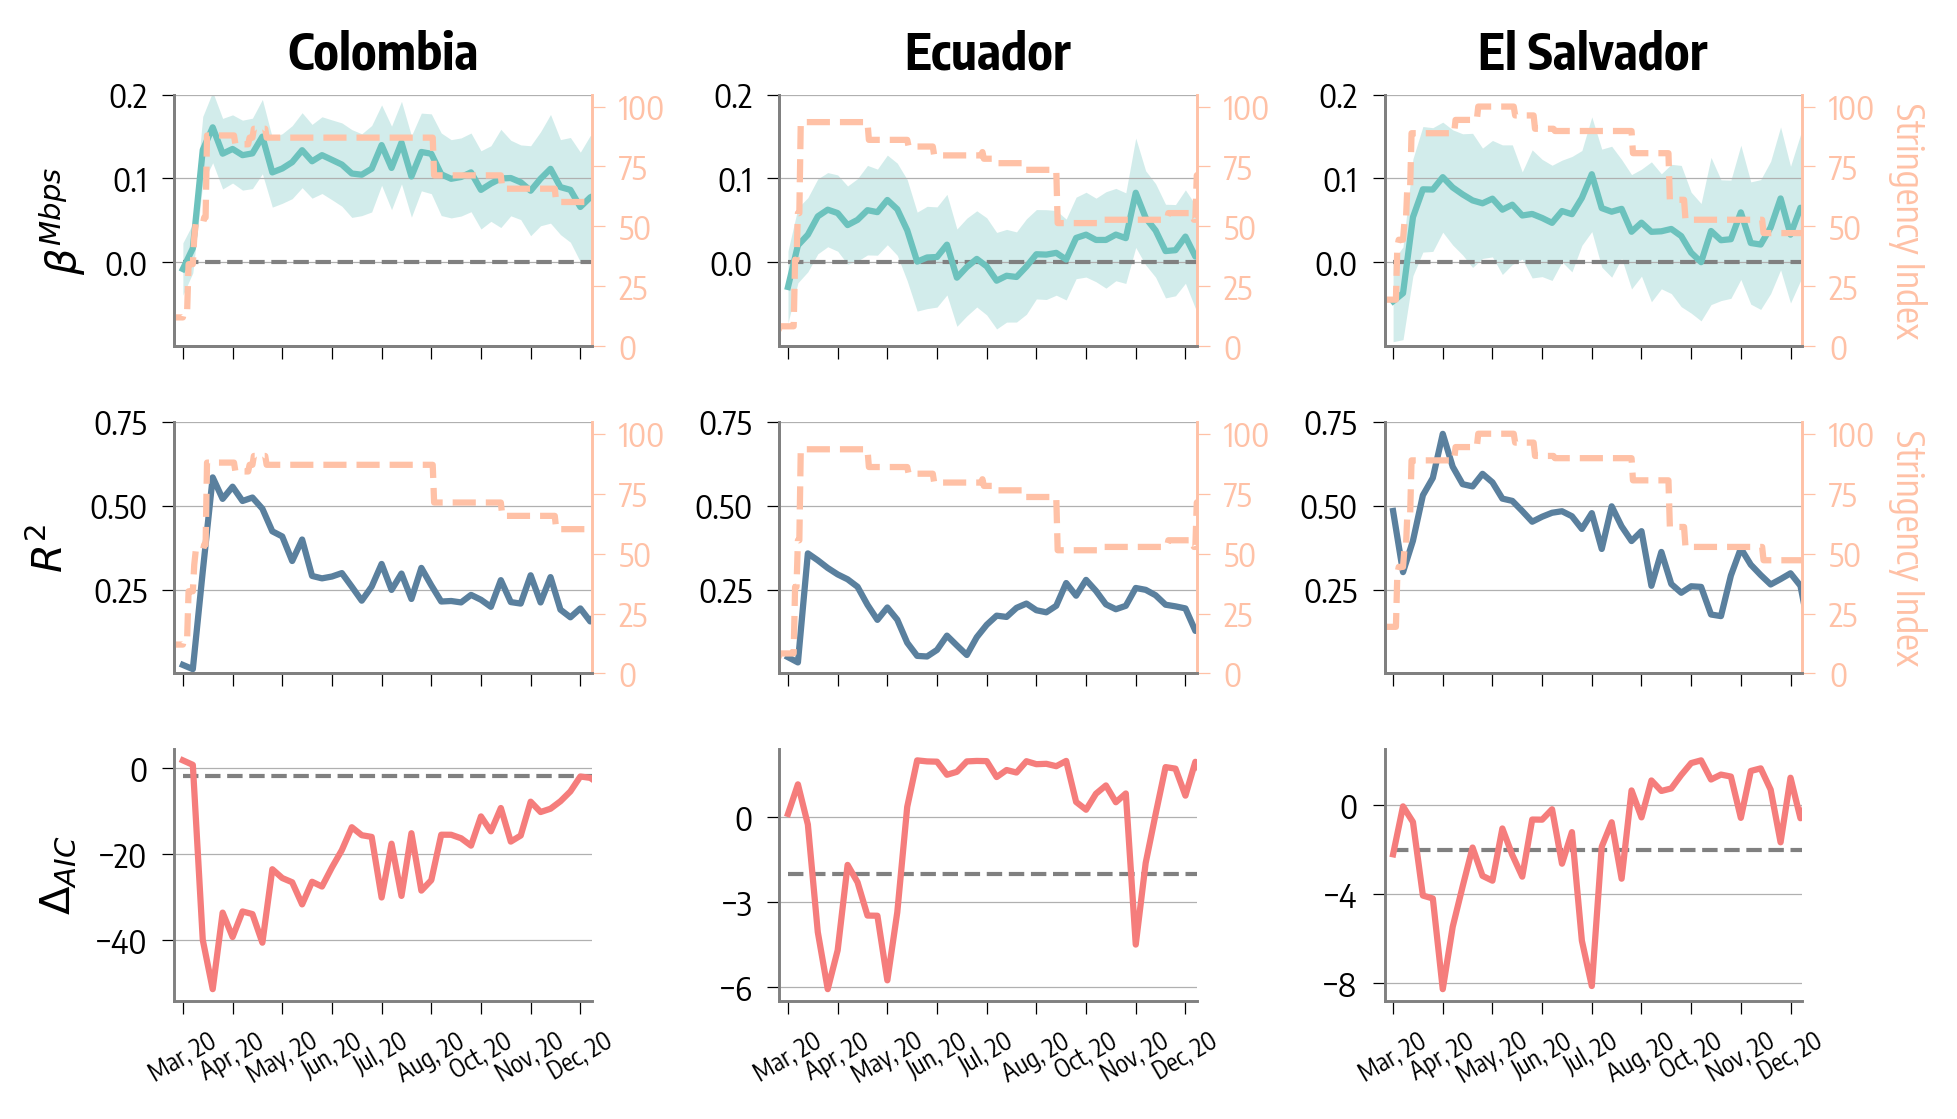

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=300, sharex=True, figsize=(7, 4))

plot_country("colombia", "max_movs", axes[0,0], axes[1,0], axes[2,0], "Colombia", label=True)
plot_country("ecuador", "max_movs", axes[0,1], axes[1,1], axes[2,1], "Ecuador")
plot_country("el-salvador", "max_movs", axes[0,2], axes[1,2], axes[2,2], "El Salvador")

plt.subplots_adjust(hspace=0.3, wspace=0.45)

plt.savefig("./img/coeffs_time_maxmovs.pdf", bbox_inches="tight")

In [5]:
def plot_policy(ax_str, country, color, label_xcoord=1.11, label=False):

    """
    This function plot the stringency index
    :param ax_str: axis
    :param country: name of the country
    :param color: color to use
    :param label_xcoord: x coordinate of the y label
    """
    # import data
    policy = import_policy(country, path_to_data="../../data/")
    # plot stringency index
    ax_str.plot(policy["StringencyIndex"], color=color, linestyle='--')
    # format dates
    ax_str.xaxis.set_major_formatter(DateFormatter("%b, %y"))
    # labels and title
    ax_str.tick_params(axis="x", rotation=30)
    if label:
        ax_str.set_ylabel("Stringency Index", fontsize=9, rotation=270, color=color)
    ax_str.yaxis.set_label_coords(x=label_xcoord, y=0.5)
    ax_str.yaxis.set_major_locator(plt.MaxNLocator(5))
    ax_str.tick_params(axis="y", color=color, labelcolor=color, labelsize=8)
    # spines
    ax_str.spines["top"].set_visible(False)
    ax_str.spines['right'].set_edgecolor(color)
    # ax lim 
    ax_str.set_ylim(0, 105)
    ax_str.set_xlim(datetime(2020, 3, 2), datetime(2020, 12, 21))

def plot_country(country, ycol, ax1, ax2, ax3, title, label=False):
    
    # import data
    coeffs = import_coeffs(country, ycol)
    
    # get data
    r2s, delta_r2s, delta_aics = [], [], []
    med_mbps, q1_mbps, q2_mbps = [], [], []
    for i in range(len(dates)):
        r2s.append(coeffs['complete'][i]['OLS']['r2'])
        delta_r2s.append(coeffs['complete'][i]['OLS']['r2'] - coeffs['complete_nombps'][i]['OLS']['r2'])
        delta_aics.append(coeffs['complete'][i]['OLS']['aic'] - coeffs['complete_nombps'][i]['OLS']['aic'])
        med, q1, q2 = get_stats_OLS(coeffs, "download_mbps_fixed", i, complete=True)
        med_mbps.append(med)
        q1_mbps.append(q1)
        q2_mbps.append(q2)
        
    df = pd.DataFrame(data={"r2s": r2s, "delta_r2s": delta_r2s, "delta_aics": delta_aics,
                        "med_mbps": med_mbps, "q1_mbps": q1_mbps, "q2_mbps": q2_mbps}, index=dates)

    df = df.resample("W").mean()
    #.mean().resample("D").mean()
    #df = df.fillna(method='ffill')

    
    ax1.plot(df.index, df.med_mbps, color=colors[0])
    ax1.fill_between(df.index, df.q1_mbps, df.q2_mbps, alpha=0.3, linewidth=0, color=colors[0])
    ax2.plot(df.index, df.r2s, color=colors[1])
    ax3.plot(df.index, df.delta_aics, color=colors[3])
    
    ax1.set_title(title, weight='bold')
    if label:
        ax1.set_ylabel("$\\beta^{Mbps}$")
        ax2.set_ylabel("$R^2$")
        ax3.set_ylabel("$\\Delta_{AIC}$")
    
    for ax in [ax1, ax2, ax3]:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis='y', labelsize=8)
        
    ax1.set_ylim(-0.1, 0.3)
    ax2.set_ylim(0.0, 0.7)
    ax3.yaxis.set_major_locator(plt.MaxNLocator(3))
    
    ax1.hlines(0, df.index[0], df.index[-1], linestyle="--", color='grey', linewidth=1)
    ax3.hlines(-2, df.index[0], df.index[-1], linestyle="--", color='grey', linewidth=1)
    
    ax1.set_yticks([0.0, 0.1, 0.2])
    ax2.set_yticks([0.25, 0.5, 0.75])
    
    if country == "el-salvador":
        label = True
    else:
        label = False
    plot_policy(ax1.twinx(), country, colors[4], label_xcoord=1.3, label=label)
    plot_policy(ax2.twinx(), country, colors[4], label_xcoord=1.3, label=label)
    
    ax1.grid(axis="y", linewidth=0.3)
    ax2.grid(axis="y", linewidth=0.3)
    ax3.grid(axis="y", linewidth=0.3)

    ax3.set_xticks([df.index[i] for i in np.arange(0, len(df.index), 5)])
    ax3.set_xticklabels([df.index[i].strftime("%b, %y") for i in np.arange(0, len(df.index), 5)])
    ax3.tick_params(axis='x', rotation=30, labelsize=6)

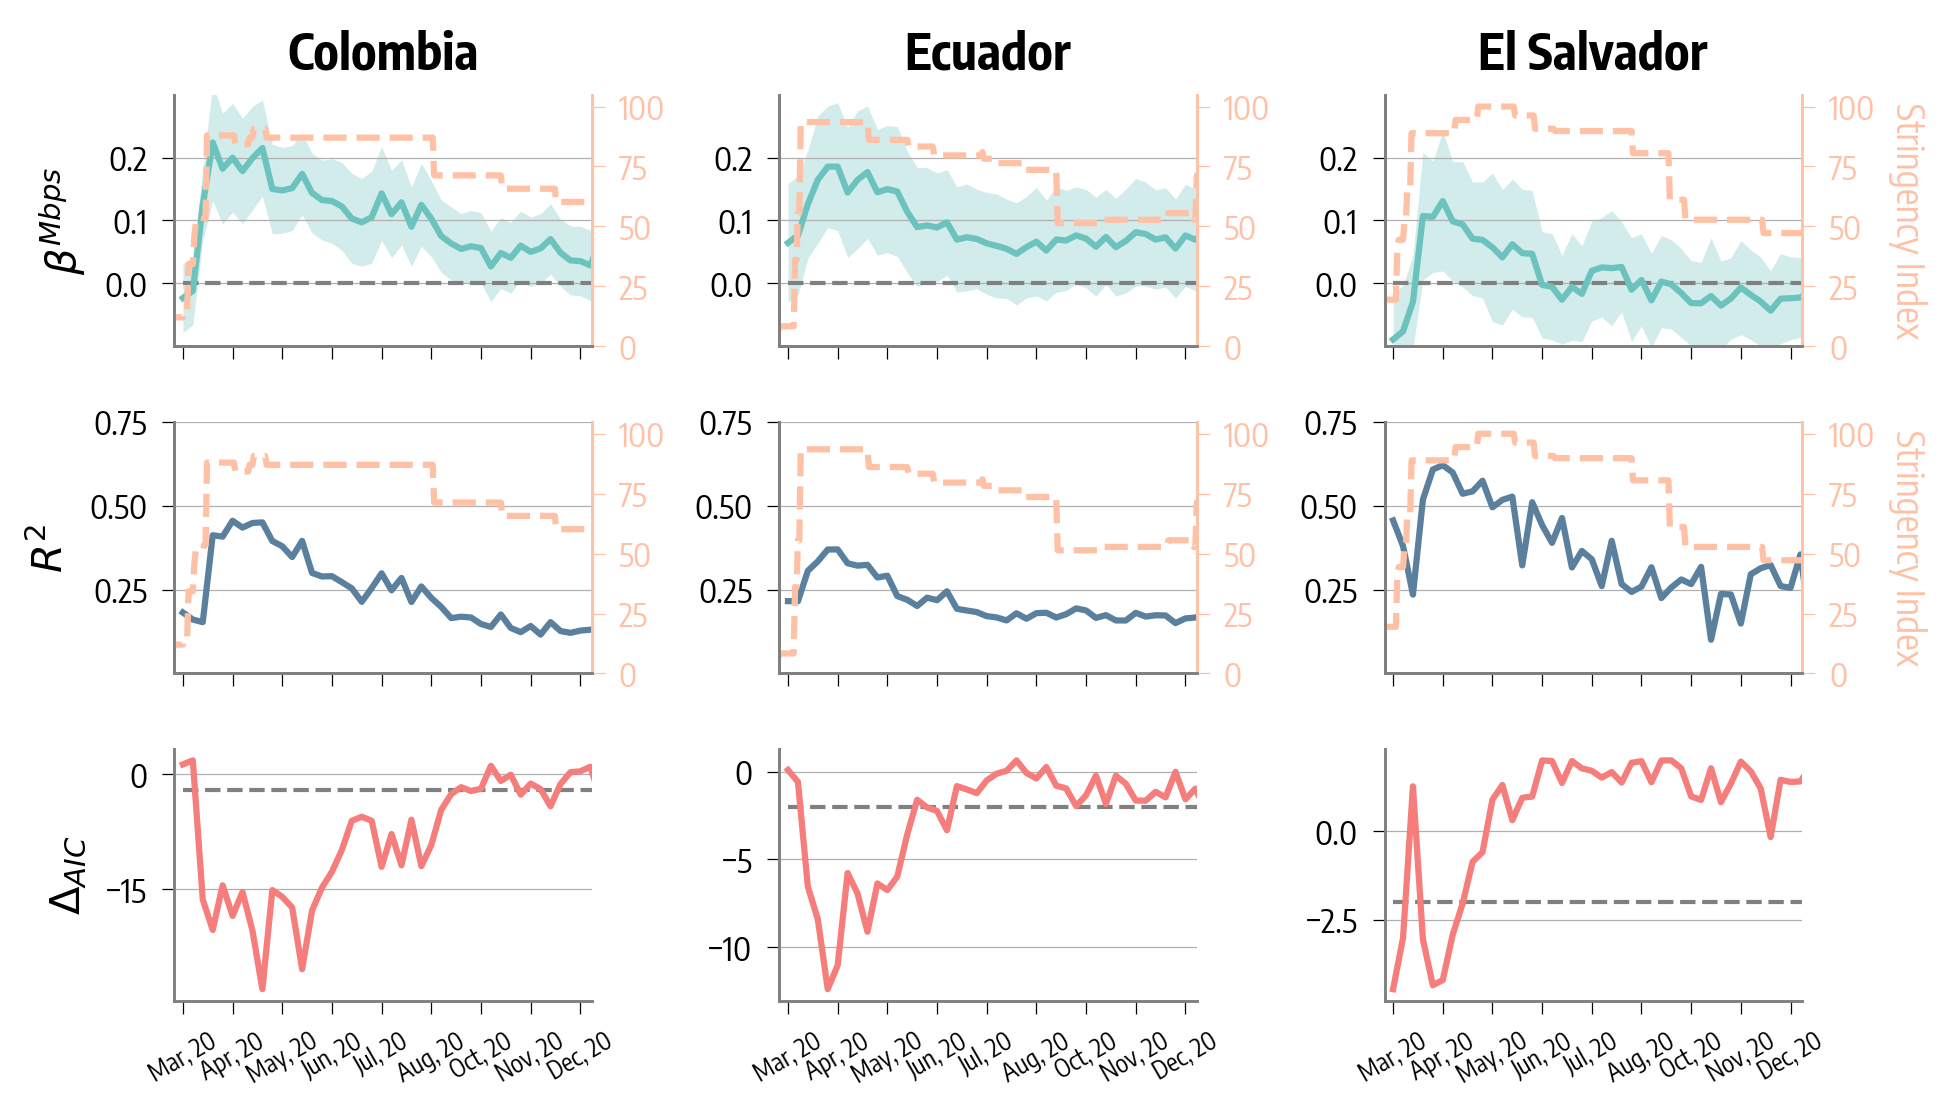

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=300, sharex=True,  figsize=(7, 4))

plot_country("colombia", "max_stay", axes[0,0], axes[1,0], axes[2,0], "Colombia", label=True)
plot_country("ecuador", "max_stay", axes[0,1], axes[1,1], axes[2,1], "Ecuador")
plot_country("el-salvador", "max_stay", axes[0,2], axes[1,2], axes[2,2], "El Salvador")

plt.subplots_adjust(hspace=0.3, wspace=0.45)

plt.savefig("./img/coeffs_time_maxstay.pdf", bbox_inches="tight")